In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))
import matplotlib.pyplot as plt

# Any results you write to the current directory are saved as output.

In [2]:
df_train = pd.read_csv('DataFolder/train.csv')
df_test = pd.read_csv('DataFolder/test.csv')
Y = df_train['Survived']

## Overview

In [3]:
df_train[:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Histograms

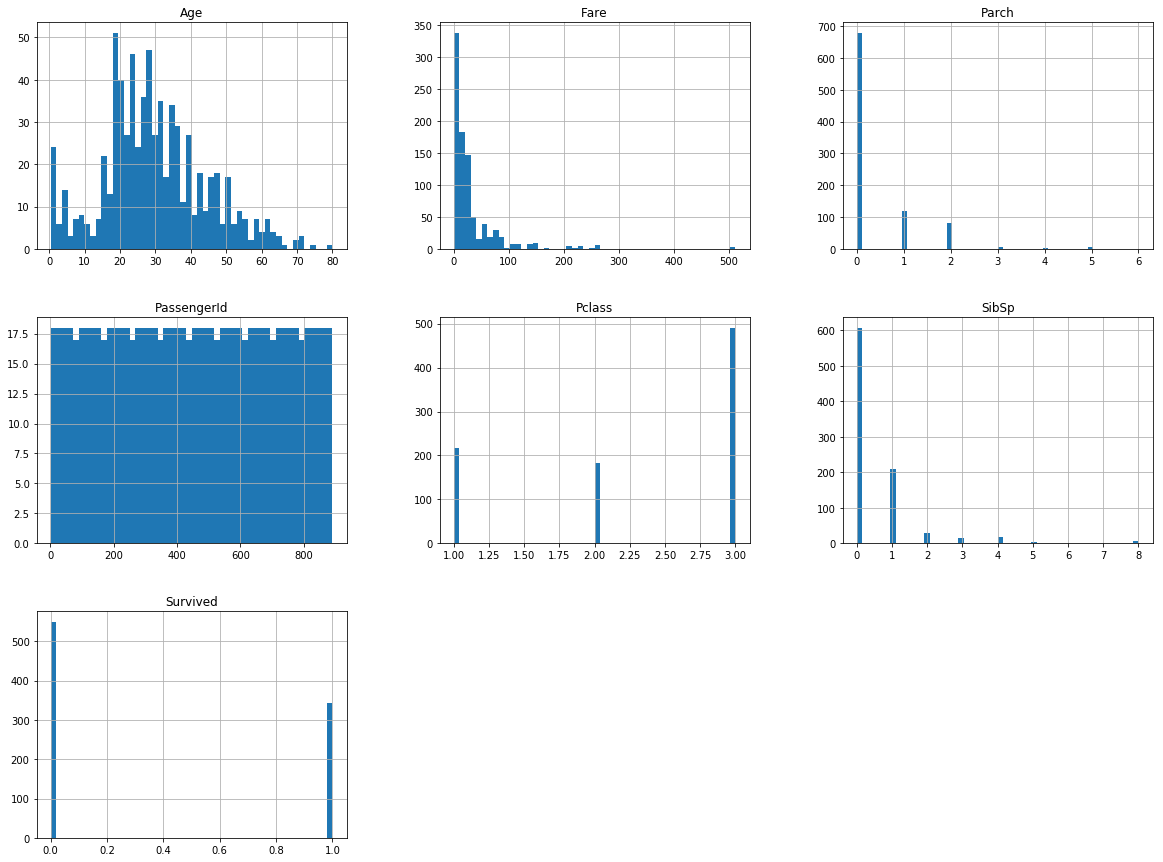

In [4]:
df_train.hist(bins=50, figsize=(20, 15))
plt.show()

## Information on columns

In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Build of my Transformers

In [6]:
#Custom Transformer which drop colunmns
from sklearn.base import TransformerMixin
class DropTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cat=['Ticket', 'Fare', 'Cabin', 'Name', 'SibSp', 'Parch', 'PassengerId']
        Xnew = X.drop(cat, axis=1)
        return Xnew

In [7]:
#Custom Transformer get dummies of my categorical columns
class GetDummiesTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        features_totransform = ['Sex', 'Embarked', 'Pclass', 'Title']
        for var in features_totransform:
            X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var)], axis=1)
        return X

In [8]:
#Custom Transformer for impute median age into NaN values
class Imputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Age'] = X['Age'].fillna(df_train['Age'].median())
        return X


In [9]:
#Custom Transformer for extract Title of people
class Title(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for i in X:
            X['Title']=X['Name'].str.extract('([A-Za-z]+)\.', expand=False)  # Use REGEX to define a search pattern
        return X

In [10]:
#Custom Transformer obtains the number of person of the same family
class Family(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for i in X:
            X['Family']=X['SibSp'] + X['Parch']
        return X

## My Pipelines

In [11]:
#Pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([ 
        ('imp', Imputer()),
        ('title', Title()),
        ('family', Family()),
        ('drop', DropTransformer()),
        ('encoder', GetDummiesTransformer())
    ])

df_train_tr = pipeline.fit_transform(df_train)
df_test_tr = pipeline.transform(df_test)



df_train_tr contrains 28 columns wheareas df_test_tr contains only 19 columns..

A lot of Titles are not given

In [12]:
#Custom Transformer for modify the Title into other caterogies
class TitleTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for i in X:
            X['Title']=X['Title'].replace(['Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev'], 'Officer')
            X['Title']=X['Title'].replace(['Lady', 'Countess', 'Sir', 'Jonkheer', 'Dona', 'Master'], 'Royalty')
            X['Title']=X['Title'].replace('Mlle', 'Miss')
            X['Title'] = X['Title'].replace('Ms', 'Miss')
            X['Title'] = X['Title'].replace('Mme', 'Mrs')
            
        return X


In [13]:
#Pipeline
from sklearn.pipeline import Pipeline
pipeline2= Pipeline([ 
        ('imp', Imputer()),
        ('title', Title()),
        ('family', Family()),
        ('drop', DropTransformer()),
        ('titlet', TitleTransformer()),
        ('encoder', GetDummiesTransformer())
    ])

df_train_tr = pipeline2.fit_transform(df_train)
df_test_tr = pipeline2.transform(df_test)

## Classifier

In [14]:
from sklearn.model_selection import GridSearchCV

X_train = df_train_tr.drop(['Survived'], axis=1).values
X_test = df_test_tr
y_train_1 = (df_train['Survived'] == 1)


SGDClassifier

In [15]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)


sgd_clf.fit(X_train, y_train_1)





C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [16]:
Some_data = X_train[10]
Some_data_predict = sgd_clf.predict([Some_data])
print('Is he survived ? ', Some_data_predict, 'real issue is ', Y[10])



Is he survived ?  [ True] real issue is  1


Accuracy on samples

In [17]:
#Calcul of the exact rate : more than 90% ! But there's only 1 / 10 to have a 3
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_1, cv=3, scoring="accuracy")

C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol 

array([0.71380471, 0.81818182, 0.38383838])

Confusion matrix

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_1, y_train_pred)

C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol 

array([[297, 252],
       [ 70, 272]], dtype=int64)

In [19]:
#Precision / recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)#0.39492753623188404 39% true when he said "Survived"
recall_score(y_train_1, y_train_pred)#0.956140350877193 95% of the Survived are covered

#Combo between precision & recall : F1
from sklearn.metrics import f1_score
f1_score(y_train_1, y_train_pred)

0.6281755196304849

Configure Threshold to optimize results

C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol 

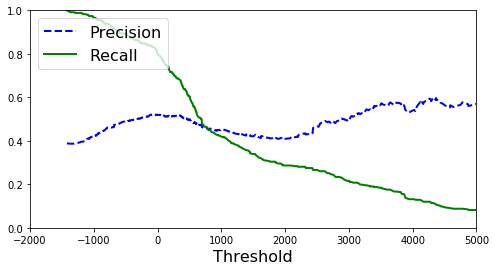

In [20]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])   
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-2000, 5000])
plt.show()

Best parameters for SGDClassifier

In [21]:
y_train_pred_90 = (y_scores > 2000)
print(precision_score(y_train_1, y_train_pred_90))

print(recall_score(y_train_1, y_train_pred_90))

0.4100418410041841
0.28654970760233917


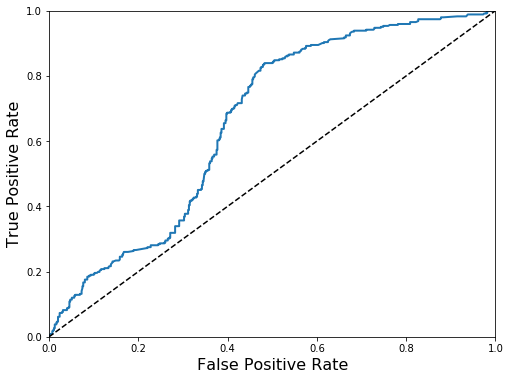

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_1, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

Final Score

In [23]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_1, y_scores)

0.6608080614407907

RandomForest Classifier

In [24]:
from  sklearn.ensemble  import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

grid_search = GridSearchCV(forest_clf,param_grid = rf_param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_search.fit(X_train, y_train_1)

forest_clf = grid_search.best_estimator_
print(grid_search.best_params_)


y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_1, cv=3,
                                    method="predict_proba")


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.8s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   55.1s finished


{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [25]:
#Calcul of the exact rate : more than 76% ! better than the previous
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf, X_train, y_train_1, cv=3, scoring="accuracy")

array([0.80808081, 0.85185185, 0.82828283])

In [26]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(forest_clf, X_train, y_train_1, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_1, y_train_pred)

array([[501,  48],
       [104, 238]], dtype=int64)

In [27]:
#Precision / recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)#0.728125 73% of Survived is written : it's true
recall_score(y_train_1, y_train_pred)#0.6812865497076024 68% of the among of Survived is cover

#On peut combiner precision_score avec le recall_score en une métrique unique : F1
from sklearn.metrics import f1_score
f1_score(y_train_1, y_train_pred)

0.7579617834394904

In [28]:
from sklearn.metrics import roc_curve


y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_1, y_scores_forest)



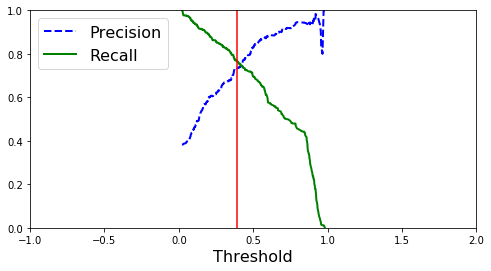

In [29]:
from sklearn.metrics import precision_recall_curve

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_1, y_scores_forest)

def plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest):
    plt.plot(thresholds_forest, precisions_forest[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds_forest, recalls_forest[:-1], "g-", label="Recall", linewidth=2)
    plt.axvline(x=0.39,color='red')
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest)
plt.xlim([-1, 2])
plt.show()

In [30]:
y_train_pred_90 = (y_scores_forest > 0.39)
print(precision_score(y_train_1, y_train_pred_90))

print(recall_score(y_train_1, y_train_pred_90))

0.7346368715083799
0.7690058479532164


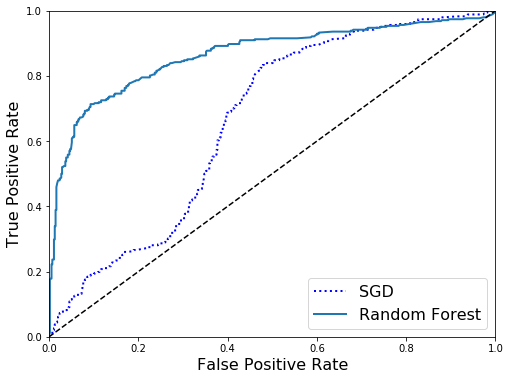

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [32]:
Random_Forest = roc_auc_score(y_train_1, y_scores_forest)

In [33]:
forest_clf.fit(X_train, y_train_1)
y_final = forest_clf.predict_proba(X_test)
y_final = pd.DataFrame(y_final)

predict_mine = np.where(y_final > 0.39, 1, 0)
predict_mine = pd.DataFrame(predict_mine)
predict_mine = predict_mine[1]


In [34]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": predict_mine
    })
submission.to_csv("Forest.csv", index=False)

Gradient Boosting

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_clf = GradientBoostingClassifier(random_state=42)

gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

grid_search = GridSearchCV(gradient_clf,param_grid = gb_param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_search.fit(X_train,y_train_1)

gradient_clf = grid_search.best_estimator_

print(grid_search.best_params_)

y_probas_gradient = cross_val_predict(gradient_clf, X_train, y_train_1, cv=3,
                                    method="predict_proba")


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   20.1s finished


{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 300}


In [36]:
cross_val_score(gradient_clf, X_train, y_train_1, cv=3, scoring="accuracy")
#Seems to be better than the RandomForest

array([0.80808081, 0.83838384, 0.81481481])

In [37]:
y_train_pred = cross_val_predict(gradient_clf, X_train, y_train_1, cv=3)

confusion_matrix(y_train_1, y_train_pred)

array([[503,  46],
       [114, 228]], dtype=int64)

In [38]:
#Precision / recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)#0.8235294117647058 82% of time "Survived" is written : it's true
recall_score(y_train_1, y_train_pred)#0.695906432748538 69% of the among of Survived is cover

f1_score(y_train_1, y_train_pred)

0.7402597402597403

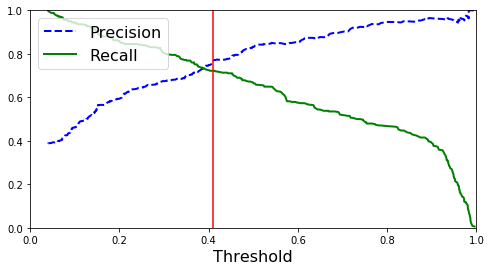

In [39]:
y_scores_gradient = y_probas_gradient[:, 1] # score = proba of positive class
fpr_gradient, tpr_gradient, thresholds_gradient = roc_curve(y_train_1, y_scores_gradient)

from sklearn.metrics import precision_recall_curve
precisions_gradient, recalls_gradient, thresholds_gradient = precision_recall_curve(y_train_1, y_scores_gradient)

def plot_precision_recall_vs_threshold(precisions_gradient, recalls_gradient, thresholds_gradient):
    plt.plot(thresholds_gradient, precisions_gradient[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds_gradient, recalls_gradient[:-1], "g-", label="Recall", linewidth=2)
    plt.axvline(x=0.41,color='red')
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_gradient, recalls_gradient, thresholds_gradient)
plt.xlim([0, 1])
plt.show()

In [40]:
y_train_pred_90 = (y_scores_gradient > 0.41)
print(precision_score(y_train_1, y_train_pred_90))

print(recall_score(y_train_1, y_train_pred_90))

0.7694704049844237
0.7222222222222222


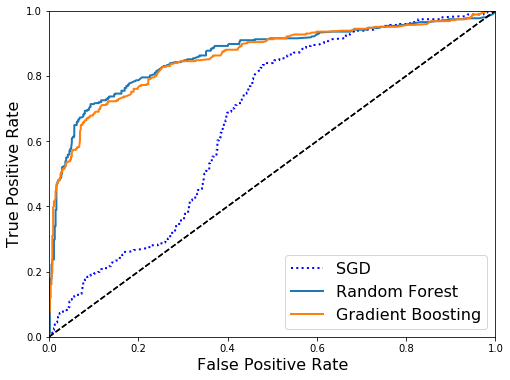

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_gradient, tpr_gradient, "Gradient Boosting")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [42]:
Gradient = roc_auc_score(y_train_1, y_scores_gradient)

In [43]:
gradient_clf.fit(X_train, y_train_1)
y_final = gradient_clf.predict_proba(X_test)
y_final = pd.DataFrame(y_final)

predict_mine = np.where(y_final > 0.41, 1, 0)
predict_mine = pd.DataFrame(predict_mine)
predict_mine = predict_mine[1]

In [44]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": predict_mine
    })
submission.to_csv("Gradient.csv", index=False)

AdaBoostClassifier


In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=42)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

grid_search = GridSearchCV(ada_clf,param_grid = ada_param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_search.fit(X_train,y_train_1)

ada_clf = grid_search.best_estimator_

print(grid_search.best_params_)

y_probas_ada = cross_val_predict(ada_clf, X_train, y_train_1, cv=3,
                                    method="predict_proba")


Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Done  83 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:    8.3s finished


{'algorithm': 'SAMME.R', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 0.001, 'n_estimators': 2}


In [46]:
cross_val_score(ada_clf, X_train, y_train_1, cv=3, scoring="accuracy")
#Seems to be better than the RandomForest

array([0.77104377, 0.8013468 , 0.76430976])

Doesn't seems to be better than Gradient Boosting

In [47]:
y_train_pred = cross_val_predict(ada_clf, X_train, y_train_1, cv=3)

confusion_matrix(y_train_1, y_train_pred)

array([[466,  83],
       [114, 228]], dtype=int64)

In [48]:
#Precision / recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)#0.7470588235294118 74% it's true when "Survived" is written
recall_score(y_train_1, y_train_pred)#0.7426900584795322 74% of the among of Survived is cover
f1_score(y_train_1, y_train_pred)

0.6983154670750382

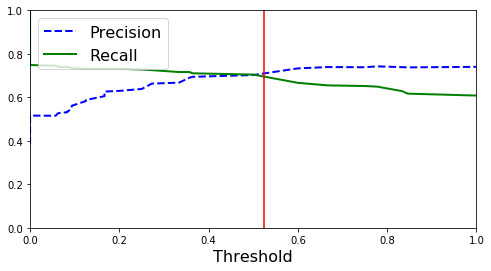

In [49]:
y_scores_ada = y_probas_ada[:, 1] # score = proba of positive class
fpr_ada, tpr_ada, thresholds_adat = roc_curve(y_train_1, y_scores_ada)

from sklearn.metrics import precision_recall_curve
precisions_ada, recalls_ada, thresholds_ada = precision_recall_curve(y_train_1, y_scores_ada)

def plot_precision_recall_vs_threshold(precisions_ada, recalls_ada, thresholds_ada):
    plt.plot(thresholds_ada, precisions_ada[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds_ada, recalls_ada[:-1], "g-", label="Recall", linewidth=2)
    plt.axvline(x=0.525,color='red')
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_ada, recalls_ada, thresholds_ada)
plt.xlim([0, 1])
plt.show()

In [50]:
y_train_pred_90 = (y_scores_ada > 0.525)
print(precision_score(y_train_1, y_train_pred_90))

print(recall_score(y_train_1, y_train_pred_90))

0.7331189710610932
0.6666666666666666


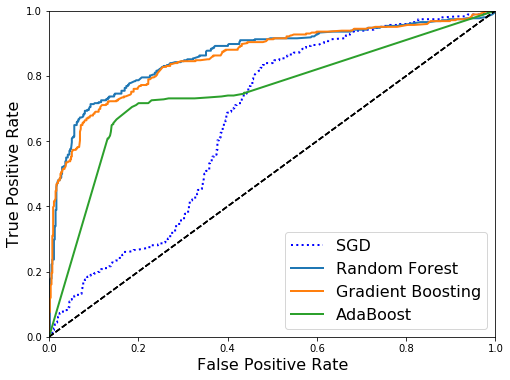

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_gradient, tpr_gradient, "Gradient Boosting")
plot_roc_curve(fpr_ada, tpr_ada, "AdaBoost")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [52]:
Ada = roc_auc_score(y_train_1, y_scores_ada)

In [53]:
ada_clf.fit(X_train, y_train_1)
y_final = ada_clf.predict_proba(X_test)
y_final = pd.DataFrame(y_final)

predict_mine = np.where(y_final > 0.525, 1, 0)
predict_mine = pd.DataFrame(predict_mine)
predict_mine = predict_mine[1]

In [54]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": predict_mine
    })
submission.to_csv("Ada.csv", index=False)

Voting

In [55]:

from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[
        ('lr', forest_clf), ('rf', gradient_clf), ('adb', ada_clf)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train_1)
predictions=eclf1.predict(X_train)
predictions

test_predictions=eclf1.predict(X_test)

test_predictions=test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": test_predictions
    })

submission.to_csv("titanic_submission.csv", index=False)

C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Optimisation 

Instead of fillna() with the median value of Age, I'm will try to fill with a value based on a regression

In [56]:
df_train = pd.read_csv('DataFolder/train.csv')
df_test = pd.read_csv('DataFolder/test.csv')

In [57]:
#Creation of a test set with Age = NaN
df_test_Age = df_train[np.isnan(df_train['Age'])]
df_test_Age = df_test_Age.reset_index(drop=True)

#Creation of a train set with Age different from NaN
df_train_Age = df_train[df_train['Age']>0]
df_train_Age = df_train_Age.reset_index(drop=True)


#Labels of my train set for fitting my regression
df_train_Age_Labels = df_train_Age['Age']
df_train_Age_Labels = df_train_Age_Labels.reset_index(drop=True)


#Creation of a Dataframe in order to keep the survived columns (because i'm gonna drop their ID)
df_survived = pd.DataFrame()
df_survived['Survived'] = pd.concat([df_test_Age['Survived'], df_train_Age['Survived']], ignore_index=True)

In [58]:
#Another pipeline..
from sklearn.pipeline import Pipeline


#Custom Transformer which drop colunmns
from sklearn.base import TransformerMixin
class DropTransformer2(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cat=['Ticket', 'Fare', 'Cabin', 'Name', 'SibSp', 'Parch', 'PassengerId','Age', 'Survived']
        Xnew = X.drop(cat, axis=1)
        return Xnew


pipeline_tmp= Pipeline([ 
        ('title', Title()),
        ('family', Family()),
        ('drop', DropTransformer2()),
        ('titlet', TitleTransformer()),
        ('encoder', GetDummiesTransformer())
    ])

df_train_temp = pipeline_tmp.fit_transform(df_train_Age)
df_test_temp = pipeline_tmp.transform(df_test_Age)


In [59]:
X_train_Age = df_train_temp
Y_train_Age = df_train_Age_Labels
X_test_Age = df_test_temp

In [60]:
from  sklearn.ensemble  import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

forest_reg = RandomForestRegressor(random_state=42)

## Search grid for optimal parameters
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train_Age, Y_train_Age)

forest_reg = grid_search.best_estimator_
print(grid_search.best_params_)

{'max_features': 4, 'n_estimators': 30}


In [61]:
forest_reg.fit(X_train_Age, Y_train_Age)

df_test_temp['Age']=pd.DataFrame(forest_reg.predict(X_test_Age))


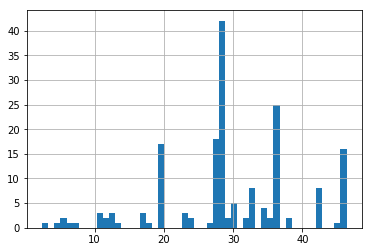

In [62]:
df_test_temp['Age'].hist(bins=50)
plt.show()

In [63]:
df_train_temp['Age']=Y_train_Age

In [64]:
#Concatenation of my two data sets
df_train_final = pd.concat([df_test_temp, df_train_temp], ignore_index=True)
df_train_final['Survived']=df_survived['Survived']

In [65]:
#Pipeline
from sklearn.pipeline import Pipeline
pipeline2= Pipeline([ 
        ('imp', Imputer()),
        ('title', Title()),
        ('family', Family()),
        ('drop', DropTransformer()),
        ('titlet', TitleTransformer()),
        ('encoder', GetDummiesTransformer())
    ])

df_train_tr = df_train_final
df_test_tr = pipeline2.transform(df_test)

## Classifier

In [66]:
from sklearn.model_selection import GridSearchCV

X_train = df_train_tr.drop(['Survived'], axis=1).values
X_train1 = df_train_tr.drop(['Survived'], axis=1)
X_test = df_test_tr
y_train_1 = (df_train_tr['Survived'] == 1)

In [67]:
Age=X_test['Age']
Tempo=X_test.drop(['Age'], axis=1)
Tempo['Age']=Age
X_test = Tempo


SGDClassifier

In [68]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)


sgd_clf.fit(X_train, y_train_1)





C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [69]:
Some_data = X_train[10]
Some_data_predict = sgd_clf.predict([Some_data])
print('Is he survived ? ', Some_data_predict, 'real issue is ', Y[10])



Is he survived ?  [ True] real issue is  1


Accuracy on samples

In [70]:
#Calcul of the exact rate : more than 90% ! But there's only 1 / 10 to have a 3
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_1, cv=3, scoring="accuracy")

C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol 

array([0.78787879, 0.43097643, 0.76430976])

Confusion matrix

In [71]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_1, y_train_pred)

C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol 

array([[319, 230],
       [ 72, 270]], dtype=int64)

In [72]:
#Precision / recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)#0.39492753623188404 39% true when he said "Survived"
recall_score(y_train_1, y_train_pred)#0.956140350877193 95% of the Survived are covered

#Combo between precision & recall : F1
from sklearn.metrics import f1_score
f1_score(y_train_1, y_train_pred)

0.6413301662707839

Configure Threshold to optimize results

C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol 

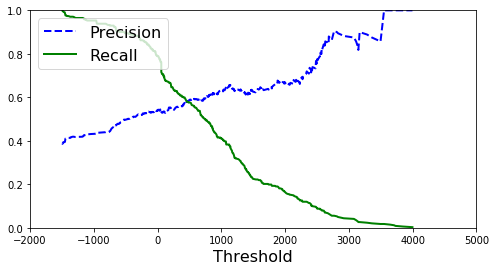

In [73]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])   
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-2000, 5000])
plt.show()

Best parameters for SGDClassifier

In [74]:
y_train_pred_90 = (y_scores > 2000)
print(precision_score(y_train_1, y_train_pred_90))

print(recall_score(y_train_1, y_train_pred_90))

0.6666666666666666
0.16374269005847952


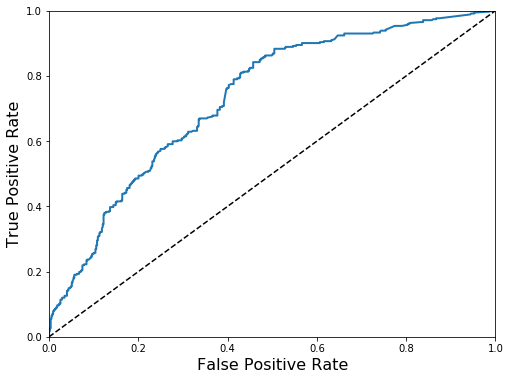

In [75]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_1, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

Final Score

In [76]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_1, y_scores)

0.7317957157617785

RandomForest Classifier

In [77]:
from  sklearn.ensemble  import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

grid_search = GridSearchCV(forest_clf,param_grid = rf_param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_search.fit(X_train, y_train_1)

forest_clf = grid_search.best_estimator_
print(grid_search.best_params_)


y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_1, cv=3,
                                    method="predict_proba")


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   39.7s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   55.2s finished


{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [78]:
#Calcul of the exact rate : more than 76% ! better than the previous
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf, X_train, y_train_1, cv=3, scoring="accuracy")

array([0.74747475, 0.83838384, 0.81481481])

In [79]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(forest_clf, X_train, y_train_1, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_1, y_train_pred)

array([[487,  62],
       [116, 226]], dtype=int64)

In [80]:
#Precision / recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)
recall_score(y_train_1, y_train_pred)

#Score is based on precision & recall : F1
from sklearn.metrics import f1_score
f1_score(y_train_1, y_train_pred)

0.7174603174603175

In [81]:
from sklearn.metrics import roc_curve


y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_1, y_scores_forest)



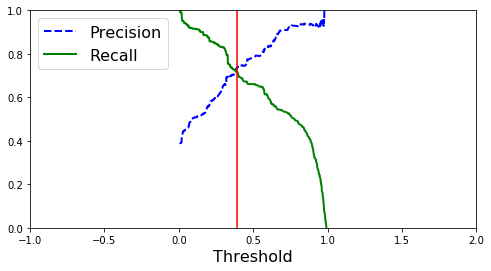

In [82]:
from sklearn.metrics import precision_recall_curve

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_1, y_scores_forest)

def plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest):
    plt.plot(thresholds_forest, precisions_forest[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds_forest, recalls_forest[:-1], "g-", label="Recall", linewidth=2)
    plt.axvline(x=0.39,color='red')
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest)
plt.xlim([-1, 2])
plt.show()

In [83]:
y_train_pred_90 = (y_scores_forest > 0.39)
print(precision_score(y_train_1, y_train_pred_90))

print(recall_score(y_train_1, y_train_pred_90))

0.7379518072289156
0.716374269005848


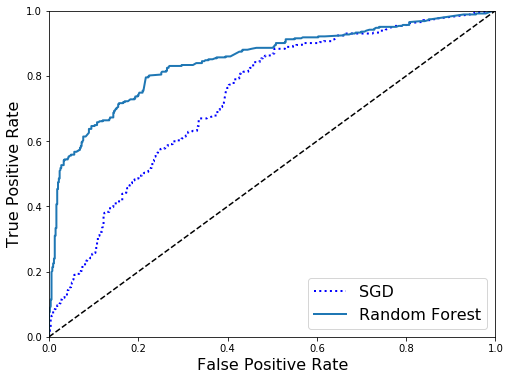

In [84]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [85]:
Random_Forest_reg = roc_auc_score(y_train_1, y_scores_forest)

In [86]:
forest_clf.fit(X_train, y_train_1)
y_final = forest_clf.predict_proba(X_test)
y_final = pd.DataFrame(y_final)

predict_mine = np.where(y_final > 0.39, 1, 0)
predict_mine = pd.DataFrame(predict_mine)
predict_mine = predict_mine[1]


In [87]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": predict_mine
    })
submission.to_csv("ForestReg.csv", index=False)

Gradient Boosting

In [88]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_clf = GradientBoostingClassifier(random_state=42)

gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

grid_search = GridSearchCV(gradient_clf,param_grid = gb_param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_search.fit(X_train,y_train_1)

gradient_clf = grid_search.best_estimator_

print(grid_search.best_params_)

y_probas_gradient = cross_val_predict(gradient_clf, X_train, y_train_1, cv=3,
                                    method="predict_proba")


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   18.5s finished


{'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 300}


In [89]:
cross_val_score(gradient_clf, X_train, y_train_1, cv=3, scoring="accuracy")
#Seems to be better than the RandomForest

array([0.81481481, 0.82828283, 0.80808081])

In [90]:
y_train_pred = cross_val_predict(gradient_clf, X_train, y_train_1, cv=3)

confusion_matrix(y_train_1, y_train_pred)

array([[497,  52],
       [111, 231]], dtype=int64)

In [91]:
#Precision / recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)#0.8235294117647058 82% des fois où il dit Survived : c'est vrai
recall_score(y_train_1, y_train_pred)#0.695906432748538 69% de la totalité des Survived a été couverte

f1_score(y_train_1, y_train_pred)

0.7391999999999999

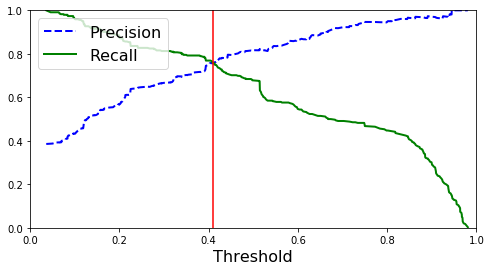

In [92]:
y_scores_gradient = y_probas_gradient[:, 1] # score = proba of positive class
fpr_gradient, tpr_gradient, thresholds_gradient = roc_curve(y_train_1, y_scores_gradient)

from sklearn.metrics import precision_recall_curve
precisions_gradient, recalls_gradient, thresholds_gradient = precision_recall_curve(y_train_1, y_scores_gradient)

def plot_precision_recall_vs_threshold(precisions_gradient, recalls_gradient, thresholds_gradient):
    plt.plot(thresholds_gradient, precisions_gradient[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds_gradient, recalls_gradient[:-1], "g-", label="Recall", linewidth=2)
    plt.axvline(x=0.41,color='red')
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_gradient, recalls_gradient, thresholds_gradient)
plt.xlim([0, 1])
plt.show()

In [93]:
y_train_pred_90 = (y_scores_gradient > 0.41)
print(precision_score(y_train_1, y_train_pred_90))

print(recall_score(y_train_1, y_train_pred_90))

0.7595307917888563
0.7573099415204678


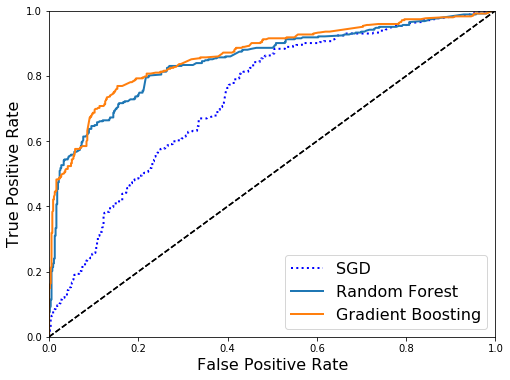

In [94]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_gradient, tpr_gradient, "Gradient Boosting")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [95]:
Gradient_Reg = roc_auc_score(y_train_1, y_scores_gradient)

In [96]:
gradient_clf.fit(X_train, y_train_1)
y_final = gradient_clf.predict_proba(X_test)
y_final = pd.DataFrame(y_final)

predict_mine = np.where(y_final > 0.41, 1, 0)
predict_mine = pd.DataFrame(predict_mine)
predict_mine = predict_mine[1]

In [97]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": predict_mine
    })
submission.to_csv("GradientReg.csv", index=False)

AdaBoostClassifier


In [98]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=42)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

grid_search = GridSearchCV(ada_clf,param_grid = ada_param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_search.fit(X_train,y_train_1)

ada_clf = grid_search.best_estimator_

print(grid_search.best_params_)

y_probas_ada = cross_val_predict(ada_clf, X_train, y_train_1, cv=3,
                                    method="predict_proba")


Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Done 142 tasks      | elapsed:    3.8s


{'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'learning_rate': 0.2, 'n_estimators': 2}


[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:    5.3s finished


In [99]:
cross_val_score(ada_clf, X_train, y_train_1, cv=3, scoring="accuracy")
#Seems to be better than the RandomForest

array([0.74747475, 0.82828283, 0.76094276])

Doesn't seems to be better than Gradient Boosting

In [100]:
y_train_pred = cross_val_predict(ada_clf, X_train, y_train_1, cv=3)

confusion_matrix(y_train_1, y_train_pred)

array([[476,  73],
       [124, 218]], dtype=int64)

In [101]:
#Precision / recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)#0.7470588235294118 74% des fois où il dit Survived : c'est vrai
recall_score(y_train_1, y_train_pred)#0.7426900584795322 74% de la totalité des Survived a été couverte
f1_score(y_train_1, y_train_pred)

0.688783570300158

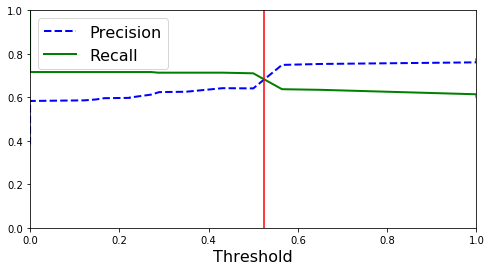

In [102]:
y_scores_ada = y_probas_ada[:, 1] # score = proba of positive class
fpr_ada, tpr_ada, thresholds_adat = roc_curve(y_train_1, y_scores_ada)

from sklearn.metrics import precision_recall_curve
precisions_ada, recalls_ada, thresholds_ada = precision_recall_curve(y_train_1, y_scores_ada)

def plot_precision_recall_vs_threshold(precisions_ada, recalls_ada, thresholds_ada):
    plt.plot(thresholds_ada, precisions_ada[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds_ada, recalls_ada[:-1], "g-", label="Recall", linewidth=2)
    plt.axvline(x=0.525,color='red')
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_ada, recalls_ada, thresholds_ada)
plt.xlim([0, 1])
plt.show()

In [103]:
y_train_pred_90 = (y_scores_ada > 0.525)
print(precision_score(y_train_1, y_train_pred_90))

print(recall_score(y_train_1, y_train_pred_90))

0.7491408934707904
0.6374269005847953


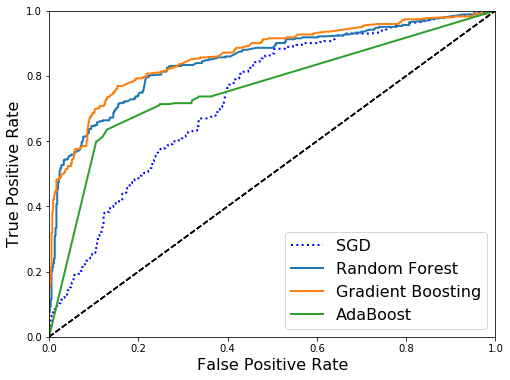

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_gradient, tpr_gradient, "Gradient Boosting")
plot_roc_curve(fpr_ada, tpr_ada, "AdaBoost")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [105]:
Ada_reg = roc_auc_score(y_train_1, y_scores_ada)

In [106]:
ada_clf.fit(X_train, y_train_1)
y_final = ada_clf.predict_proba(X_test)
y_final = pd.DataFrame(y_final)

predict_mine = np.where(y_final > 0.525, 1, 0)
predict_mine = pd.DataFrame(predict_mine)
predict_mine = predict_mine[1]

In [107]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": predict_mine
    })
submission.to_csv("AdaReg.csv", index=False)

Voting

In [108]:

from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[
        ('lr', forest_clf), ('rf', gradient_clf), ('adb', ada_clf)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train_1)
predictions=eclf1.predict(X_train)

test_predictions=eclf1.predict(X_test)

test_predictions=test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": test_predictions
    })

submission.to_csv("titanic_submissionReg.csv", index=False)

C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\anthime.biau-peyret\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [109]:
print('Random Forest :', Random_Forest)
print('Random Forest Regression :', Random_Forest_reg)
print('Gradient :', Gradient)
print('Gradient Reg :', Gradient_Reg)
print('Ada :', Ada)
print('Ada reg :', Ada_reg)

Random Forest : 0.8641416078143143
Random Forest Regression : 0.8475750700369625
Gradient : 0.8581977865124256
Gradient Reg : 0.8624665793201888
Ada : 0.7516270944513682
Ada reg : 0.7623669830313489


Using a regression doesn't appear like a real improvement of our model